In [1]:
import sys
import os

notebook_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(parent_dir)

#  В этом ноутбуке проверим насколько в целом адекватно считается дельта (в минимальном приближении)

In [2]:
import pandas as pd
import warnings
from hedge.find_hedge import FindHedge
from hedge.option_schema import OptionSchema
from hedge.implied_volatility import ImpliedVolatility
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from lss.algorithm import LongStaffSchwartz
from lss.models import NaiveModel
from lss.options import PutOption

warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('../data/server_data/dataset_cleaned.csv', index_col='Unnamed: 0')
data.drop_duplicates(subset=['id', 'dttm'], inplace=True)
data.reset_index(inplace=True, drop=True)

sample = data.sample(frac = 1).to_dict('records')[:5000]

In [4]:
def find_ap_price(option: OptionSchema, simulations: np.array):
    naive_model = NaiveModel(risk_free_rate=option.risk_free_rate*100)
    option_model = PutOption()

    lss_model = LongStaffSchwartz(
        risk_free_rate=option.risk_free_rate*100,
        option=option_model,
        strike=option.strike,
        monte_carlo_paths=simulations,
        model=naive_model,
    )
    _, AP_price = lss_model.evaluate(verbose=False)
    
    return AP_price

In [5]:
from lss.brownian import BrownianMotionSimulation

deltas = []
errors_list = []
results = []
eps = 1e-4

for el in tqdm(sample):
    try:
        # Приводим к опциону строку
        option = OptionSchema.model_validate(el)
        
        # Считаем волатильность
        implied_volatility_algo = ImpliedVolatility(option=option)
        iv = implied_volatility_algo.count()
        
        # Generate paths 
        brownian = BrownianMotionSimulation(
            S_0=option.spot_price,
            risk_free_rate=option.risk_free_rate*100,
            volatility=iv*100,
        )
        lss_paths = brownian.simulate(
            num_paths=1000, len_paths=int(option.expiration_time + 1)
        )
        

        AP_price_b = find_ap_price(option, lss_paths * (option.spot_price + eps)/option.spot_price)
        AP_price_l = find_ap_price(option, lss_paths * (option.spot_price - eps)/option.spot_price)

        # find delta
        delta_now = (AP_price_b - AP_price_l)/(2*eps)9
        
        deltas.append(delta_now)
        
        results.append(
                {
                    "date": el['dttm'],
                    "name": option.full_name,
                    "spot_price": option.spot_price,
                    "strike": option.strike,
                    "IV": iv,
                    "delta": delta_now, 
                }
        )
        
    except Exception as e:
        if str(e) == "expected non-empty vector for x":
            continue
        else:
            print(e)
            errors_list.append(e)
            continue

  0%|          | 0/5000 [00:00<?, ?it/s]

In [21]:
breaken = []
working = []

for d in deltas:
    if d < -1 - 0.1:
        breaken.append(d)
        continue
    if d > 0:
        breaken.append(d)
        continue
    working.append(d)

In [22]:
len(breaken)

2

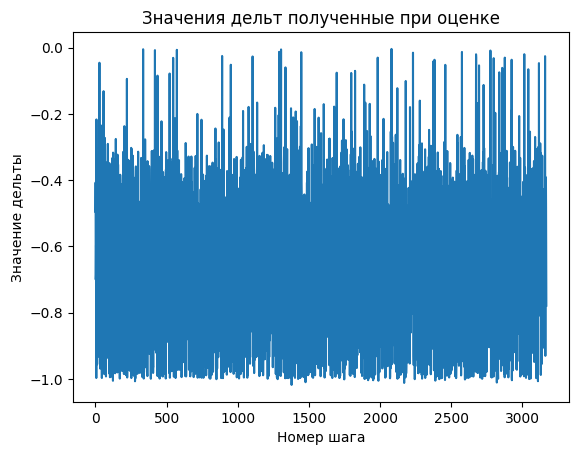

In [36]:
plt.plot(working)
plt.ylabel('Значение дельты')
plt.xlabel('Номер шага')
plt.title('Значения дельт полученные при оценке')
plt.show()

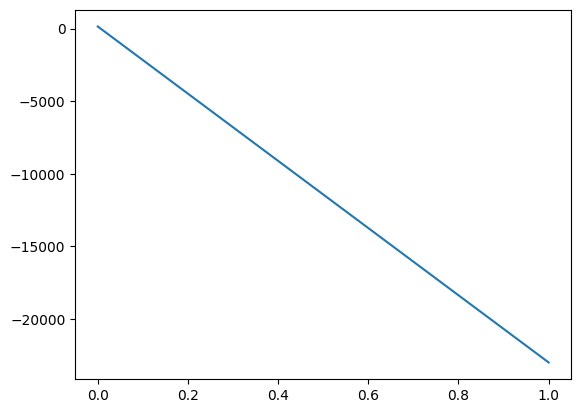

[143.65910864512443, -22987.98742285612]

In [24]:
plt.plot(breaken)
plt.show()

breaken

In [15]:
for res in results:
    if res['delta'] > 140:
        print(res)

{'date': '2023-12-29 08:00:00', 'name': 'ETH-23FEB24-3600-C', 'spot_price': 2346.84375, 'strike': 3600.0, 'IV': 0.730010986328125, 'delta': 143.65910864512443}


In [4]:
a = data[(data['id'] == 'ETH-27SEP24-1900-C') & (data['dttm'] == '2023-11-27 08:00:00')].to_dict('records')[0]

In [5]:
option = OptionSchema.model_validate(a)
# Считаем волатильность
implied_volatility_algo = ImpliedVolatility(option=option)

find_hedge = FindHedge(
    option=option,
    implied_volatility=implied_volatility_algo
)    

# Прайсим 
hedge_now, delta_now, american_option_price, implied_volatility = find_hedge.run(
    step_num=0,
    num_simulations=10000
)
print("Hedge", hedge_now)
print("Delta", delta_now)
print("AP_proce", american_option_price)
print("implied_volatility", implied_volatility)

STEP_NUM  304
X [ 940.73416667 1428.8744751  1103.98150209 ... 1524.24482014  775.28769451
  840.47355739] y
STEP_NUM  303
X [ 957.56960836 1426.86597434 1090.92721207 ... 1529.5550124   758.05440626
  832.64615448] y
STEP_NUM  302
X [ 994.3374231  1475.19119814 1094.1683444  ... 1516.63678873  750.01344223
  823.20450799] y
STEP_NUM  301
X [ 958.10812592 1462.36012735 1068.29925277 ... 1478.90469001  767.81019915
  870.18332975] y
STEP_NUM  300
X [ 976.69917611 1459.04239224 1072.04663805 ... 1447.97294116  767.75066435
  853.38594534] y
STEP_NUM  299
X [1008.3299792  1483.8682924  1089.29112488 ... 1465.20941027  799.89804115
  824.46593024] y
STEP_NUM  298
X [1025.31895724 1524.74403159 1141.58054884 ... 1517.13525693  795.37122919
  773.7519256 ] y
STEP_NUM  297
X [1040.74595548 1509.97305481 1156.47945294 ... 1572.11580005  793.65575479
  739.29819988] y
STEP_NUM  296
X [1049.45552508 1566.63933649 1132.32248429 ... 1605.778128    809.39846893
  738.70086823] y
STEP_NUM  295
X [10

In [52]:
f = lambda x: 2.786 *  x**2 - 1.049 * x + 9.882

In [53]:
eps = 1e-5
(f(2062 + eps) - f(2062 - eps))/(2*eps)

11488.415393978355